In [1]:
#Importação de pacotes
import warnings
import pandas as pd
df = pd.read_csv('saude.csv')
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import joblib # Utilizado para salvar o modelo preditivo
from sklearn.preprocessing import LabelEncoder #Utilizada para fazer o OneHotEncoding
from sklearn.metrics import mean_squared_error,precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, confusion_matrix
from imblearn import under_sampling, over_sampling #Utilizada para fazer o balanceamento de dados
from imblearn.over_sampling import SMOTE #Utilizada para fazer o balanceamento de dados
from sklearn.preprocessing import MinMaxScaler #Utilizada para fazer a padronização dos dados
from sklearn.metrics import r2_score # Utilizado para medir a acuracia do modelo preditivo
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV 
import time
warnings.filterwarnings("ignore") 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
#pd.options.display.float_format = '{:.2f}'.format


In [2]:
df.head()

,id,diagnostic,age,ges
0,1,RAQUIESTENOSIS L4-L5 Y DISCOPATIA SEVERA L5-S1,67,False
1,10,ABSCESO OVARICO,50,False
2,100,Cálculo del uréter,57,False
3,101,Cálculo del uréter,28,False
4,102,Cálculo del uréter,54,False


# MANIPULAÇÃO DE DADOS

### TRADUZINDO BASE DE DADOS

In [3]:
df_traduzida = df.rename(columns={'diagnostic':'Diagnóstico','age':'Idade'})

### EXCLUINDO COLUNA DESNECESSARIA

In [4]:
del df_traduzida['id']

### VERIFICANDO OUTLIERS

Idade : int64


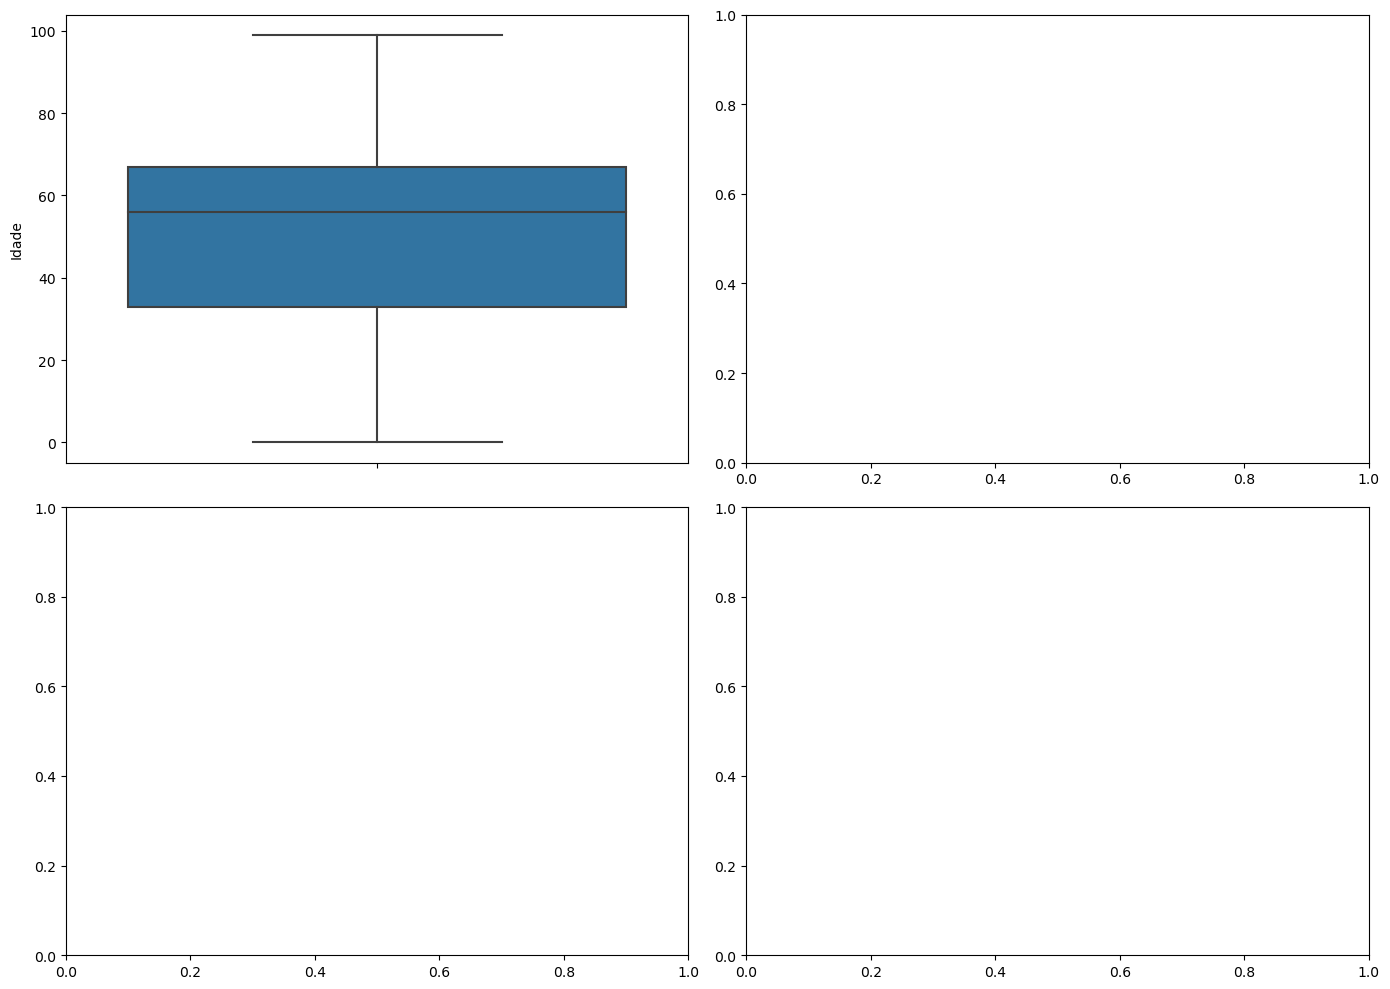

In [5]:
variaveis_numericas = []
for i in df_traduzida.columns[0:16].tolist():
        if df_traduzida.dtypes[i] == 'int64' or df_traduzida.dtypes[i] == 'float64':            
            print(i, ':' , df_traduzida.dtypes[i]) 
            variaveis_numericas.append(i)
 
    
    
    
plt.rcParams["figure.figsize"] = [14.00, 10.00]
plt.rcParams["figure.autolayout"] = True

plt.rcParams['font.size'] = 10 
plt.rcParams['axes.titlesize'] = 20

f, axes = plt.subplots(2, 2) #8 linhas e 4 colunas

linha = 0
coluna = 0
for i in variaveis_numericas:
    sns.boxplot(data = df_traduzida, y=i, ax=axes[linha][coluna])
    coluna += 1
    if coluna == 3:
        linha += 1
        coluna = 0            


### TRATANDO O OUTLIERS

In [6]:
df_traduzida['Idade'].min()   

0

In [7]:
remocao_noites_outlhiers = (df_traduzida['Idade']>1) & (df_traduzida['Idade']<100) 

In [8]:
df_traduzida = df_traduzida[remocao_noites_outlhiers]

# ANÁLISE DE DADOS EXPLORATÓRIA

In [9]:
df_traduzida.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 928 entries, 0 to 940
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Diagnóstico  928 non-null    object
 1   Idade        928 non-null    int64 
 2   ges          928 non-null    bool  
dtypes: bool(1), int64(1), object(1)
memory usage: 22.7+ KB


In [10]:
df_traduzida.describe()

,Idade
count,928.000000
mean,51.148707
std,22.277196
min,2.000000
25%,34.750000
50%,56.000000
75%,68.000000
max,99.000000


### VERIFICANDO AS LINHAS DUPLICADAS E NULAS

In [11]:
df_traduzida.duplicated().sum()

56

In [12]:
df_traduzida.isnull().sum()

Diagnóstico    0
Idade          0
ges            0
dtype: int64

## Total de valores únicos de cada variável

In [13]:
valores_unicos = []
for i in df_traduzida.columns[0:12].tolist():
    print(i, ':', len(df_traduzida[i].astype(str).value_counts()))
    valores_unicos.append(len(df_traduzida[i].astype(str).value_counts()))

Diagnóstico : 537
Idade : 92
ges : 2


### ANALISANDO AS IDADE ENTRE: CRIANÇAS, JOVENS, ADULTOS E IDOSOS

### CRIANÇAS

### ANALISANDO AS MAIORES DOENÇAS ENTRE AS CRIANÇAS

In [14]:
criança = df_traduzida[df_traduzida['Idade']<=10] 

In [15]:
numero = criança.groupby(["Diagnóstico"]).count()["Idade"].rename('Número de Diagnóstico')
# Dataframe para os resultados
dados_usuarios = pd.DataFrame({"Número de Diagnóstico":numero})

dados_usuarios.sort_values("Número de Diagnóstico", ascending=False).head(5)

,Número de Diagnóstico
Diagnóstico,
FIMOSIS,12
AMIGDALAS,3
HTAA,2
HERNIA UMBILICAL,2
ADENOAMIGDALAS,2


### ANALISANDO A PRIORIDADE DAS CRIANÇAS

In [16]:
criança.groupby(['ges']).size()

ges
False    54
True      1
dtype: int64

### JOVENS

In [17]:
jovens = df_traduzida.query('Idade > 10 and Idade <= 29')

In [18]:
numero = jovens.groupby(["Diagnóstico"]).count()["Idade"].rename('Número de Diagnóstico')
# Dataframe para os resultados
dados_usuarios = pd.DataFrame({"Número de Diagnóstico":numero})

dados_usuarios.sort_values("Número de Diagnóstico", ascending=False).head(5)

,Número de Diagnóstico
Diagnóstico,
CX DE TERCEROS MOLARES,16
COLELITIASIS,7
INCLUSIONES DENTARIAS,5
AMIGDALAS,4
NEVO,3


### ANALISANDO A PRIORIDADE DOS JOVENS

In [19]:
jovens.groupby(['ges']).size()

ges
False    144
True       6
dtype: int64

### ADULTOS

In [20]:
adultos = df_traduzida.query('Idade > 29 and Idade <= 59')

### ANALISANDO AS MAIORES DOENÇAS ENTRE OS ADULTOS

In [21]:
numero = adultos.groupby(["Diagnóstico"]).count()["Idade"].rename('Número de Diagnóstico')
# Dataframe para os resultados
dados_usuarios = pd.DataFrame({"Número de Diagnóstico":numero})

dados_usuarios.sort_values("Número de Diagnóstico", ascending=False).head(5)

,Número de Diagnóstico
Diagnóstico,
COLELITIASIS,21
MULTIPARIDAD,8
Cálculo del uréter,8
MIOMATOSIS UTERINA,6
VARICES PIERNA DERECHA,6


### ANALISANDO A PRIORIDADE DOS ADULTOS

In [22]:
adultos.groupby(['ges']).size()

ges
False    233
True      96
dtype: int64

### IDOSOS

In [23]:
idosos = df_traduzida.query('Idade > 59 and Idade <= 99')

### ANALISANDO AS MAIORES DOENÇAS ENTRE OS IDOSOS

In [24]:
numero = idosos.groupby(["Diagnóstico"]).count()["Idade"].rename('Número de Diagnóstico')
# Dataframe para os resultados
dados_usuarios = pd.DataFrame({"Número de Diagnóstico":numero})

dados_usuarios.sort_values("Número de Diagnóstico", ascending=False).head(5)

,Número de Diagnóstico
Diagnóstico,
CATARATA OD,16
CBC,15
CATARATA ODI SAN JOSE,14
CATARATA OI,13
Hiperplasia de la Próstata HPB,10


### ANALISANDO A PRIORIDADE DOS IDOSOS

In [25]:
idosos.groupby(['ges']).size()

ges
False    239
True     155
dtype: int64

# MACHINE LEARNING

### PRÉ PROCESSAMENTO

In [26]:
#del df_traduzida['id']

In [27]:
# Cria o encoder
lb = LabelEncoder()

# Aplica o encoder nas variáveis que estão com string
df_traduzida['ges'] = lb.fit_transform(df_traduzida['ges'])
df_traduzida['Diagnóstico'] = lb.fit_transform(df_traduzida['Diagnóstico'])

# Remove valores missing eventualmente gerados
df_traduzida.dropna(inplace = True)

In [28]:
# Importa a função
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE

# Seed para reproduzir o mesmo resultado
seed = 100

# Cria o balanceador SMOTE
smote_bal = SMOTE(random_state = seed)

# Separa X e y
X = df_traduzida.iloc[:, :-1].values
y = df_traduzida.iloc[:, -1].values

# Aplica o balanceador
X_res, y_res = smote_bal.fit_resample(X, y)

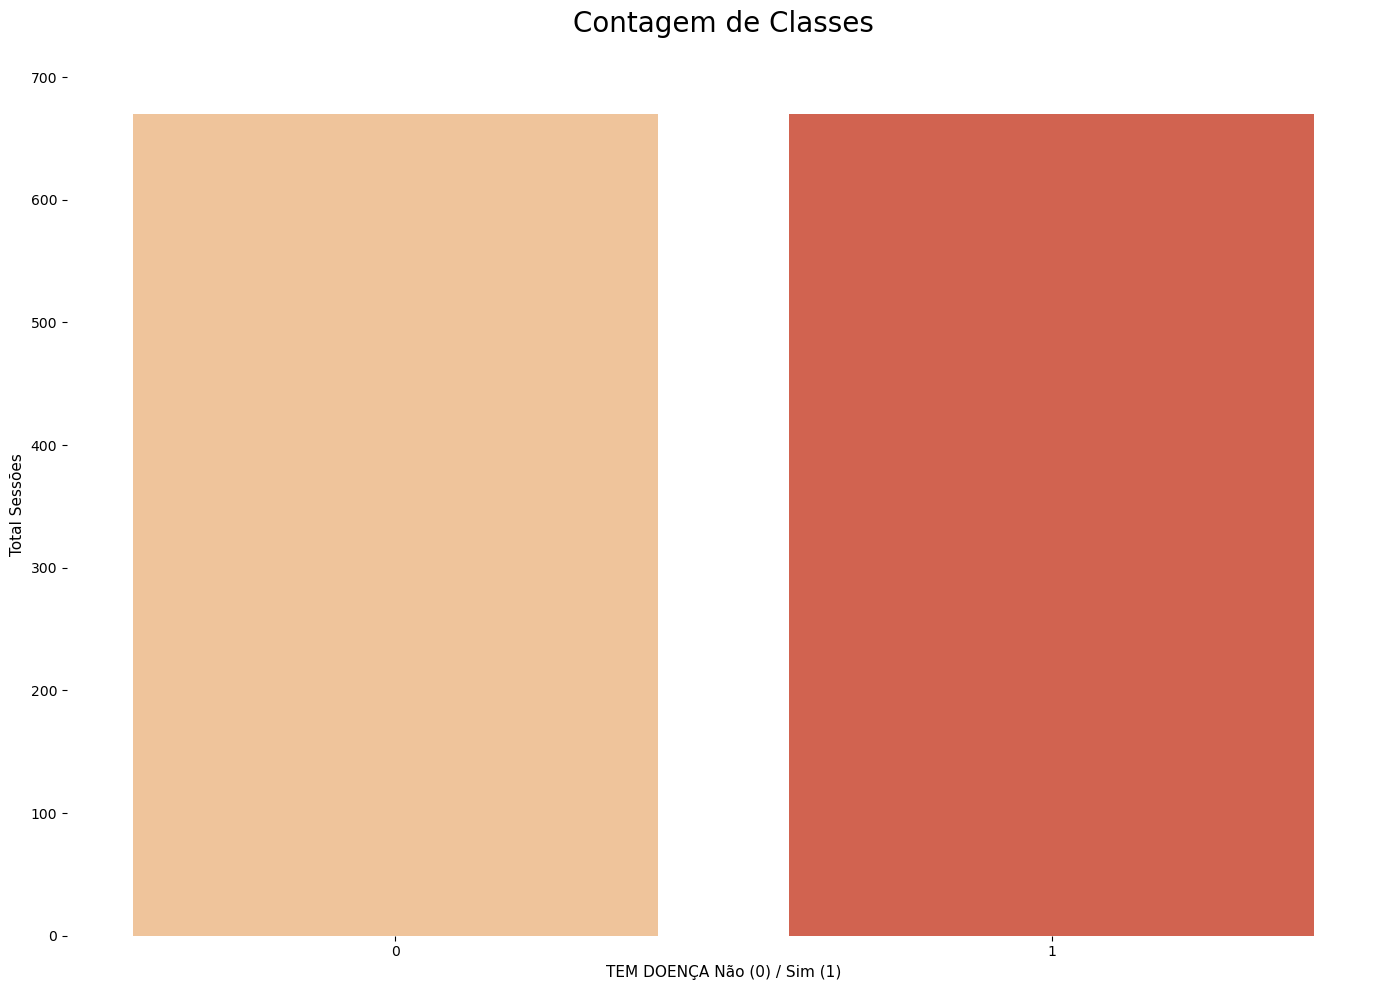

In [29]:
# Plot 
sns.countplot(y_res, palette = "OrRd")
plt.box(False)
plt.xlabel('TEM DOENÇA Não (0) / Sim (1)', fontsize = 11)
plt.ylabel('Total Sessões', fontsize = 11)
plt.title('Contagem de Classes\n')
plt.show()

# RandomForest

In [30]:
# SEPRANDO AS VARIAVEIS PARA TREINAMENTO

# Train Test Split:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

In [31]:
# Importing métricas de avaliação:
from sklearn.metrics import mean_squared_error, r2_score

In [32]:
#Random Forest Regressor:
from sklearn.ensemble import RandomForestClassifier
RandomForestClassifier = RandomForestClassifier()
RandomForestClassifier = RandomForestClassifier.fit(X_train, y_train)

#Prediction:
y_pred = RandomForestClassifier.predict(X_test)

#Scores:
print(r2_score(y_test, y_pred))
print(mean_squared_error(y_test, y_pred))

0.4488146551724138
0.11827956989247312


## INFELIZMENTE NOSSO MODELO NÃO FICOU BOM, TEREMOS QUE MELHORAR A PERFOMARCE E TESTAR OUTROS ALGORTIMOS

# GridSearchCV - RandomForest

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV 
# Construtor do Modelo
randomForest = RandomForestClassifier()

In [34]:
# Valores para o grid de hiperparametros
n_estimators = np.array([100,150,300])
max_depth = np.array([10,20])
criterion = np.array(["gini", "entropy"])
max_features = np.array(["sqrt", "log2"])
min_samples_split = np.array([1,2])
min_samples_leaf = np.array([1,2])
bootstrap = np.array(["True","False"])

# Grid de hiperparâmetros
grid_parametros = dict(n_estimators = n_estimators,
                       max_depth = max_depth,
                       criterion = criterion,
                       max_features = max_features,
                       min_samples_split = min_samples_split,
                       min_samples_leaf = min_samples_leaf,
                       bootstrap = bootstrap)

# Criando o modelo com o Grid de Hiperparametros
randomForest = GridSearchCV(randomForest, grid_parametros, cv = 3, n_jobs = 8)

# Treinando os modelos
inicio = time.time()
randomForest.fit(X_train, y_train)
fim = time.time()

# Obtendo e visualizando os parametros treinados
treinos_rf = pd.DataFrame(randomForest.cv_results_)

# Acurácia em Treino
print(f"Acurácia em Treinamento: {randomForest.best_score_ :.2%}")
print("")
print(f"Hiperparâmetros Ideais: {randomForest.best_params_}")
print("")
print("Tempo de Treinamento do Modelo: ", round(fim - inicio,2))
print("")
print("Numero de treinamentos realizados: ", treinos_rf.shape[0])

Acurácia em Treinamento: 91.06%

Hiperparâmetros Ideais: {'bootstrap': 'True', 'criterion': 'entropy', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 150}

Tempo de Treinamento do Modelo:  25.94

Numero de treinamentos realizados:  192


# RandomizedSearchCV - RandomForest

In [35]:
# Construtor do Modelo
randomForest = RandomForestClassifier()

In [36]:
# Valores para o grid de hiperparametros
n_estimators = np.array([100,150,300])
max_depth = np.array([10,20])
criterion = np.array(["gini", "entropy"])
max_features = np.array(["sqrt", "log2"])
min_samples_split = np.array([1,2])
min_samples_leaf = np.array([1,2])
bootstrap = np.array(["True","False"])

# Numero de iterações do RandonSearch
iteracoes = 50

# Grid de hiperparâmetros
grid_parametros = dict(n_estimators = n_estimators,
                       max_depth = max_depth,
                       criterion = criterion,
                       max_features = max_features,
                       min_samples_split = min_samples_split,
                       min_samples_leaf = min_samples_leaf,
                       bootstrap = bootstrap)

# Criando o modelo com o Grid de Hiperparametros
randomForest = RandomizedSearchCV(randomForest, grid_parametros, cv = 3, n_jobs = 8, n_iter = iteracoes)

# Treinando os modelos
inicio = time.time()
randomForest.fit(X_train, y_train)
fim = time.time()

# Obtendo e visualizando os parametros treinados
treinos_rf = pd.DataFrame(randomForest.cv_results_)

# Acurácia em Treino
print(f"Acurácia em Treinamento: {randomForest.best_score_ :.2%}")
print("")
print(f"Hiperparâmetros Ideais: {randomForest.best_params_}")
print("")
print("Tempo de Treinamento do Modelo: ", round(fim - inicio,2))
print("")
print("Numero de treinamentos realizados: ", treinos_rf.shape[0])

Acurácia em Treinamento: 91.22%

Hiperparâmetros Ideais: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20, 'criterion': 'gini', 'bootstrap': 'True'}

Tempo de Treinamento do Modelo:  5.93

Numero de treinamentos realizados:  50


# KNN (K Nearest Neighbors)

In [37]:
import ipywidgets as widgets
from IPython.display import display
style = {'Descrição_Variáveis': 'initial'}

# import KNN library
from sklearn.neighbors import KNeighborsClassifier

# configure params for the model.
neigh_wig = widgets.Dropdown(options=[1, 10, 30, 100], 
                             description="Number of Neighbours = ", style=style)

display(neigh_wig)

Dropdown(description='Number of Neighbours = ', options=(1, 10, 30, 100), value=1)

In [38]:
Maquina_Preditiva = KNeighborsClassifier(n_neighbors=neigh_wig.value)

#Feed the training data to the classifier
Maquina_Preditiva = Maquina_Preditiva.fit(X_train,y_train)

#Predicting the species for test set
y_pred = Maquina_Preditiva.predict(X_test)

print("\n---------------------------\n")
print("Valores Preditos com dados de Teste :\n",y_pred)
print("\n---------------------------\n")
print("Valores Reais com dados de teste :\n",y_test)


---------------------------

Valores Preditos com dados de Teste :
 [0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0
 0 0 1 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0 0 0 1 0 0 0 0 0
 1 0 1 1 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0
 0 0 1 0 1 0 0 1 0 0 0 0 1 0 0 0 0 1 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 1 1
 0 0 1 0 0 0 0 1 0 0 1 1 1 0 1 0 1 1 0 0 1 0 1 1 0 1 1 0 0 1 0 0 0 0 0 1 0
 0 0 1 1 0 0 1 0 1 0 1 1 0 0 0 0 0 1 1 0 0 1 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0
 1 0 1 0 0 0 0 0 0 1 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1
 0 1 0 0 0 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0]

---------------------------

Valores Reais com dados de teste :
 [0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 1 0 0 1 0 0 0 0 1 0 0 1 1 0 0
 0 0 1 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0
 1 0 1 1 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 1 0 0 1 0 0
 0 0 1 0 1 0 0 1 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 1 

In [39]:
#8 Calculando a Acurácia
from sklearn import metrics
print("Acurácia da Máquina = ", metrics.accuracy_score(y_test, y_pred))

Acurácia da Máquina =  0.8924731182795699


# XGBoost

In [40]:
#!pip install xgboost
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier


In [41]:
# Definindo o tamanho dos dados de treino e de teste
teste_size = 0.33
seed = 7

# Criando o dataset de treino e de teste
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size = teste_size, random_state = seed)


In [48]:
# Criando o modelo
modelo = XGBClassifier()

# Treinando o modelo
modelo.fit(X_treino, y_treino)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [49]:
# Fazendo previsões
y_pred = modelo.predict(X_teste)
previsoes = [round(value) for value in y_pred]


In [50]:
# Avaliando as previsões
accuracy = accuracy_score(y_teste, previsoes)
print("Acurácia: %.2f%%" % (accuracy * 100.0))



Acurácia: 94.14%


# REGRESSÃO LOGISTICA

In [51]:
from sklearn.linear_model import LogisticRegression

xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.30, random_state=42)

funcao_logistica = LogisticRegression()

funcao_logistica.fit(xtrain, ytrain);

print(funcao_logistica.score(xtest, ytest))

0.7562724014336918


# Naive Bayes

In [53]:
#4 Creating training set and testing set
from sklearn.model_selection import train_test_split
test_size = widgets.FloatSlider(min=0.01, max=0.6, value=0.2, description="Test Size :", tooltips=['Usually 20-30%'])
display(test_size)

FloatSlider(value=0.2, description='Test Size :', max=0.6, min=0.01)

In [54]:
#Divide the dataset into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X ,y, test_size=test_size.value, random_state = 0)

In [55]:
print("Training Set :\n----------------\n")
print("X = \n", X_train[:5])
print("y = \n", y_train[:5])

print("\n\nTest Set :\n----------------\n")
print("X = \n",X_test[:5])
print("y = \n", y_test[:5])

Training Set :
----------------

X = 
 [[309  29]
 [ 92  65]
 [209  20]
 [ 80  53]
 [368  58]]
y = 
 [0 1 0 1 0]


Test Set :
----------------

X = 
 [[ 23  74]
 [203  49]
 [384  65]
 [529  32]
 [477  61]]
y = 
 [1 0 0 0 0]


In [56]:
print(f"Shape of Training set is {X_train.shape}")
print(f"Shape of Testing set is {X_test.shape}")

Shape of Training set is (742, 2)
Shape of Testing set is (186, 2)


## Normalizando as variáveis

In [57]:
#Feature scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test) 

print("\n-------------------------\nDataset after Scaling:\n-------------------------\n", )

print("\nX_train :\n", X_train[:5])
print("-------------------------")
print("\nX_test :\n", X_test[:5])


-------------------------
Dataset after Scaling:
-------------------------


X_train :
 [[ 0.38216427 -0.98903682]
 [-1.01028664  0.62513508]
 [-0.25951817 -1.39257979]
 [-1.08728853  0.08707778]
 [ 0.76075692  0.31126832]]
-------------------------

X_test :
 [[-1.45304753  1.02867806]
 [-0.29801912 -0.09227465]
 [ 0.86342611  0.62513508]
 [ 1.79386566 -0.85452249]
 [ 1.46019078  0.44578265]]


In [58]:
from sklearn.naive_bayes import GaussianNB
%matplotlib inline

classifier = GaussianNB()

#Treinamento
classifier.fit(X_train,y_train)

#Previsões com dados de Teste
y_pred = classifier.predict(X_test)

print("\n---------------------------\n")
print("Predicted Values for Test Set :\n",y_pred)
print("\n---------------------------\n")
print("Actual Values for Test Set :\n",y_test)



---------------------------

Predicted Values for Test Set :
 [1 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 0 1 0 0 1 1 0 0 1 1 0 1 0 0 1 0
 0 0 0 1 0 1 0 0 0 1 0 1 0 0 0 1 0 0 1 0 0 1 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0
 0 1 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 1 0 0 0 1 1 0 1 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 0 1 0 1 0 0
 1]

---------------------------

Actual Values for Test Set :
 [1 0 0 0 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0 1 1 0 0 1 0 1 1 0 0 0 0 1 1 0 0 1 0
 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 1 1 1 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 0 1 0 1 0 0 0 1 0 0 0 1 1 0 0 0 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0
 0]


In [59]:
#8 Claculating the Accuracy of the predictions
from sklearn import metrics
print("Prediction Accuracy = ", metrics.accuracy_score(y_test, y_pred))

#9 Comparing Actual and Predicted Salaries for he test set
print("\nActual vs Predicted Salaries \n------------------------------\n")
error_df = pd.DataFrame({"Actual" : y_test,
                         "Predicted" : y_pred})

error_df

Prediction Accuracy =  0.8118279569892473

Actual vs Predicted Salaries 
------------------------------



,Actual,Predicted
0,1,1
1,0,0
2,0,0
3,0,0
4,0,0
5,0,0
6,0,0
7,1,1
8,0,0
9,1,1


In [60]:
#Using confusion matrix to find the accuracy
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test,y_pred)

accuracy = cm.diagonal().sum()/cm.sum()

print("\n---------------------------\n")
print("Accuracy of Predictions = ",accuracy)

print("\n---------------------------\n")
print(classification_report(y_test, y_pred))
print(cm)


---------------------------

Accuracy of Predictions =  0.8118279569892473

---------------------------

              precision    recall  f1-score   support

           0       0.88      0.87      0.88       142
           1       0.60      0.64      0.62        44

    accuracy                           0.81       186
   macro avg       0.74      0.75      0.75       186
weighted avg       0.82      0.81      0.81       186

[[123  19]
 [ 16  28]]


# SVM - Support Vector Machines

### Modelo Baseline com Kernel Linear e Dados Padronizados (Scaled)

In [61]:
from sklearn import svm

In [62]:
# Divisão em Dados de Treino e Teste.
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size = 0.3, random_state = 7)

In [63]:
from sklearn.preprocessing import StandardScaler
# Padronização
sc = StandardScaler()
X_treino_scaled = sc.fit_transform(X_treino)
X_teste_scaled = sc.transform(X_teste)

In [64]:
X_treino_scaled

array([[ 0.86374268, -0.59941772],
       [-0.8039084 , -1.35162152],
       [-0.75883675, -0.4224286 ],
       ...,
       [ 0.43234259,  0.10853879],
       [-0.8039084 ,  0.37402248],
       [-0.86185766,  1.48020453]])

In [65]:
X_teste_scaled

array([[ 1.81668615, -0.82065413],
       [ 0.38083213,  1.3032154 ],
       [ 0.02025893, -0.73215957],
       [-1.18379803,  1.21472084],
       [-0.91980693,  1.48020453],
       [-1.0743383 ,  0.68375345],
       [ 0.9732024 ,  1.70144094],
       [ 0.29712764, -0.02420306],
       [-1.46710554, -1.08613783],
       [-0.99063381,  0.59525889],
       [ 1.40460249, -1.57285793],
       [ 0.90237552,  0.02004422],
       [-1.02282784,  0.37402248],
       [ 0.62550681, -0.46667588],
       [ 1.74585927, -0.73215957],
       [-0.91980693, -0.11269762],
       [-0.59142776, -0.99764326],
       [-0.96487858,  1.21472084],
       [ 0.5289247 , -0.99764326],
       [-0.1793441 , -0.06845034],
       [-0.69444868, -1.48436336],
       [-0.99063381,  0.28552791],
       [ 0.32288287, -1.08613783],
       [ 1.21787708,  0.99348443],
       [-0.23729336, -0.4224286 ],
       [-0.07632318,  1.61294637],
       [ 0.31644406,  0.8164953 ],
       [ 0.89593671, -1.21887967],
       [-1.35764582,

In [66]:
# Cria o modelo
from sklearn import svm
modelo_v1 = svm.SVC(kernel = 'linear')

In [67]:
# Treinamento
start = time.time()
modelo_v1.fit(X_treino_scaled, y_treino)
end = time.time()
print('Tempo de Treinamento do Modelo foi de :', end - start)

Tempo de Treinamento do Modelo foi de : 0.012989997863769531


In [68]:
# Previsões
previsoes_v1 = modelo_v1.predict(X_teste_scaled)

In [69]:
# Dicionário de métricas e metadados
SVM_dict_v1 = {'Modelo':'SVM',
               'Versão':'1',
               'Kernel':'Linear com Dados Padronizados',
               'Precision':precision_score(previsoes_v1, y_teste),
               'Recall':recall_score(previsoes_v1, y_teste),
               'F1 Score':f1_score(previsoes_v1, y_teste),
               'Acurácia':accuracy_score(previsoes_v1, y_teste),
               'AUC':roc_auc_score(y_teste, previsoes_v1)}

In [70]:
# Print
print("Métricas em Teste:\n")
SVM_dict_v1

Métricas em Teste:



{'Modelo': 'SVM',
 'Versão': '1',
 'Kernel': 'Linear com Dados Padronizados',
 'Precision': 0.5365853658536586,
 'Recall': 0.6567164179104478,
 'F1 Score': 0.5906040268456376,
 'Acurácia': 0.7813620071684588,
 'AUC': 0.7099170484090628}

### Otimização de Hiperparâmetros com Grid Search e Kernel RBF

In [71]:
# Cria o modelo
modelo_v2 = svm.SVC(kernel = 'rbf')

In [72]:
# Valores para o grid
C_range = np.array([50., 100., 200.])
gamma_range = np.array([0.3*0.001,0.001,3*0.001])

In [73]:
# Grid de hiperparâmetros
svm_param_grid = dict(gamma = gamma_range, C = C_range)

In [74]:
# Grid Search
start = time.time()
modelo_v2_grid_search_rbf = GridSearchCV(modelo_v2, svm_param_grid, cv = 3)

In [75]:
# Treinamento
modelo_v2_grid_search_rbf.fit(X_treino_scaled, y_treino)
end = time.time()
print('Tempo de Treinamento do Modelo com Grid Search:', end - start)

Tempo de Treinamento do Modelo com Grid Search: 1.073089361190796


In [76]:
# Acurácia em Treino
print(f"Acurácia em Treinamento: {modelo_v2_grid_search_rbf.best_score_ :.2%}")
print("")
print(f"Hiperparâmetros Ideais: {modelo_v2_grid_search_rbf.best_params_}")

Acurácia em Treinamento: 80.74%

Hiperparâmetros Ideais: {'C': 200.0, 'gamma': 0.003}


In [77]:
# Previsões
previsoes_v2 = modelo_v2_grid_search_rbf.predict(X_teste_scaled)

In [78]:
# Dicionário de métricas e metadados
SVM_dict_v2 = {'Modelo':'SVM',
               'Versão':'2',
               'Kernel':'RBF com Tunning de Hyperparâmetros',
               'Precision':precision_score(previsoes_v2, y_teste),
               'Recall':recall_score(previsoes_v2, y_teste),
               'F1 Score':f1_score(previsoes_v2, y_teste),
               'Acurácia':accuracy_score(previsoes_v2, y_teste),
               'AUC':roc_auc_score(y_teste, previsoes_v2)}

In [79]:
# Print
print("Métricas em Teste:\n")
SVM_dict_v2

Métricas em Teste:



{'Modelo': 'SVM',
 'Versão': '2',
 'Kernel': 'RBF com Tunning de Hyperparâmetros',
 'Precision': 0.5121951219512195,
 'Recall': 0.711864406779661,
 'F1 Score': 0.5957446808510639,
 'Acurácia': 0.7956989247311828,
 'AUC': 0.7129503528537823}

In [80]:
# Concatena todos os dicionários em um dataframe do Pandas
resumo = pd.DataFrame({'Baseline':pd.Series(SVM_dict_v1),
                       'Máquina_Preditiva':pd.Series(SVM_dict_v2)})

In [81]:
resumo

,Baseline,Máquina_Preditiva
Modelo,SVM,SVM
Versão,1,2
Kernel,Linear com Dados Padronizados,RBF com Tunning de Hyperparâmetros
Precision,0.536585,0.512195
Recall,0.656716,0.711864
F1 Score,0.590604,0.595745
Acurácia,0.781362,0.795699
AUC,0.709917,0.71295


# Decision_Tree

In [82]:
from sklearn.tree import DecisionTreeClassifier

In [83]:
# Divisão em Dados de Treino e Teste.
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size = 0.3, random_state = 7)

In [84]:
# Building Decision Tree
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(max_depth = None, 
                                   max_features = None, 
                                   min_samples_leaf = 1,
                                   min_samples_split = 2,
                                   )
dt.fit(X_train, y_train)

dt_pred_train = dt.predict(X_train)


In [85]:
# Evaluation on Training set
dt_pred_train = dt.predict(X_train)
print('Training Set Evaluation F1-Score=>',f1_score(y_train,dt_pred_train))

# Evaluating on Test set
dt_pred_test = dt.predict(X_test)
print('Testing Set Evaluation F1-Score=>',f1_score(y_test,dt_pred_test))

Training Set Evaluation F1-Score=> 1.0
Testing Set Evaluation F1-Score=> 0.9230769230769231
